# Introduction

Describe CRM queries and objectives

## Imports and Loads

In [2]:
# Load Libraries and Functions

import pandas as pd
import pandas.io.sql as sqlio
import psycopg2
import psycopg2.extras
import math

class dbconnection:
    #use postgres localhost
    use_local = True

    #settings
    server_host = "appserver-01.alunos.di.fc.ul.pt" if use_local is False else "localhost"
    port = 5432
    sslmode = "allow" if use_local is False else "disable"
    dbname = "tpd012" if use_local is False else "airbnb"
    dbusername = "tpd012" if use_local is False else "postgres"
    dbpassword = "Airbnbosses69420" if use_local is False else "root"
    gssencmode = "prefer" if use_local is False else "disable"
    
# define functions

def run_sql_command(sql, conn):
    """Executes a single SQL statement from a string variable and the database credentials"""
    
    try:
        cur = conn.cursor()
        cur.execute(sql)
        conn.commit()
        success = True
    except psycopg2.DatabaseError as error:
        success = False
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

def query_table(conn, table_name):
    """Returns DataFrame with queried database table"""
    sql = "select * from {};".format(table_name)
    #return dataframe
    return sqlio.read_sql_query(sql, conn)

def insert_data(df, table_name, conn):

    """Inserts selected data into dimension table in database"""
    df_columns = df.columns
    columns = ",".join(df_columns)
    values = "VALUES({})".format(",".join(["%s" for _ in df_columns])) 
    insert_stmt = "INSERT INTO {} ({}) {}".format(table_name,columns,values)
    success = True
    
    values = [[int(val) for val in value] for value in df.values]

    try:
        cursor = conn.cursor()
        psycopg2.extras.execute_batch(cursor, insert_stmt, values)
        conn.commit()
        success = True
    except psycopg2.DatabaseError as error:
        success = False
        print('Error on table {}'.format(table_name))
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return success

def query_kpis(conn, method='score'):
    
    if method == 'cs':
        kpi = method
        kpi_name = 'Customer_Satisfaction'
    elif method == 'profit':
        kpi = method
        kpi_name = 'Monthly_Profit_Per_Property'
    elif method == 'score':
        kpi = method
        kpi_name = 'Companies_Performance'
    else:
        kpi = method
        kpi_name = 'Generic'
    
    sql = """
    select round(avg({}) * 100, 2) as {} from metrics;
    """.format(kpi, kpi_name)
    
    try:
        cur = conn.cursor()
        cur.execute(sql)
        result = cur.fetchall()[0][0]
    except psycopg2.DatabaseError as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
    return result

## Create Numerical Reviews

To facilitate queries we redo the Reviews Dimension using numerical variables

#### Pre-Process

In [30]:
# Retreive Current Reviews
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
table_name = 'review'
df_reviews = query_table(conn, table_name)
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location
0,1,Very good,Description is not accurate,Clean,Good communication,Good location
1,2,Average,Description is not accurate,Clean,Good communication,Good location
2,3,Good,Description is not accurate,Clean,Good communication,Good location
3,4,Bellow average,Description is not accurate,Clean,Good communication,Good location
4,5,Average,Description is not accurate,Clean,Bad communication,Good location


In [32]:
# Map Categorical Reviews to Numerical Values

mapping = {
    'rating': {
        'Bellow average': 0,
        'Average': 1,
        'Good': 2,
        'Very good': 3,
        'Excelent': 4
    },
    'accuracy': {
        'Description is not accurate': 0,
        'Accurate description': 1
    },
    'cleanliness': {
        'Not clean': 0,
         'Clean': 1
    },
    'communication': {
        'Bad communication': 0,
        'Good communication': 1
    },
    'location': {
        'Bad location': 0,
        'Good location': 1
    }
}
try:
    df_reviews.replace(mapping, inplace=True)
except TypeError:
    pass
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location
0,1,3,0,1,1,1
1,2,1,0,1,1,1
2,3,2,0,1,1,1
3,4,0,0,1,1,1
4,5,1,0,1,0,1


In [33]:
# Add Sum Column
df_reviews['score'] = df_reviews.sum(axis=1)
df_reviews.head()

,review_id,rating,accuracy,cleanliness,communication,location,score
0,1,3,0,1,1,1,7
1,2,1,0,1,1,1,6
2,3,2,0,1,1,1,8
3,4,0,0,1,1,1,7
4,5,1,0,1,0,1,8


#### Inject Database

In [48]:
# Insert Table
insert_sql = """
DROP TABLE IF EXISTS CS; 
CREATE TABLE CS (
REVIEW_ID SERIAL PRIMARY KEY NOT NULL,
RATING INT NOT NULL, 
ACCURACY INT NOT NULL,
CLEANLINESS INT NOT NULL,
COMMUNICATION INT NOT NULL,
LOCATION INT NOT NULL,
SCORE INT NOT NULL
);
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
run_sql_command(insert_sql, conn)

# Insert DATA
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
insert_data(df_reviews, 'CS', conn)

# Insert Constrains
insert_c = """
ALTER TABLE listings
DROP CONSTRAINT IF EXISTS constraint_fkey;
ALTER TABLE listings 
ADD CONSTRAINT cn FOREIGN KEY (review_id) REFERENCES CS (review_id);
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
success = run_sql_command(insert_c, conn)
if success is True: print('Done')

Done


## KPI's

#### Create Metrics View

In [49]:
# Normalized Customer Satisfaction Metric
norm_cs_sql = """
CREATE OR REPLACE FUNCTION normalized_cs()
RETURNS TABLE
            (
                id INT,
                normalized_cs NUMERIC
            )
AS $$
BEGIN
RETURN QUERY
    SELECT
    x.id, 1.00*(sample-min_metric)/range_metric
    FROM
        (
        SELECT
               cs.id,
               metric AS sample,
               MIN(metric) OVER () AS min_metric,
               MAX(metric) OVER () - MIN(metric) OVER () AS range_metric
        FROM
             (SELECT property.property_id as id, cs.score as metric
                FROM cs
                    INNER JOIN listings
                        ON cs.review_id = listings.review_id
                    INNER JOIN property
                        ON listings.property_id = property.property_id
                ) as cs
        ) x ;

END;
$$ LANGUAGE plpgsql;
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
success = run_sql_command(norm_cs_sql, conn)

# Normalized Profit Metric
norm_profit_sql = """
CREATE OR REPLACE FUNCTION normalized_profit()
RETURNS TABLE
            (
                id INT,
                normalized_profit NUMERIC
            )
AS $$
BEGIN
RETURN QUERY
    SELECT
    x.id, 1.00*(sample-min_metric)/range_metric as normalized_profit
    FROM
        (
        SELECT
               cs.id,
               metric AS sample,
               MIN(metric) OVER () AS min_metric,
               MAX(metric) OVER () - MIN(metric) OVER () AS range_metric
        FROM
             (SELECT p.id, AVG(rented_days * avg_price_per_night)/30 as metric
                FROM (
                     SELECT CAST(count(*) as NUMERIC) as rented_days, booking.property_id as id, AVG(booking.price_per_night) as avg_price_per_night
                     FROM booking
                              INNER JOIN date
                                         ON booking.date_id = date.date_id
                     GROUP BY property_id, month, year
                     ) as p
                GROUP BY p.id
             ) as cs
        ) x ;

END;
$$ LANGUAGE plpgsql;
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
success = run_sql_command(norm_profit_sql, conn)

In [17]:
# Create View

metrics_sql = """
DROP MATERIALIZED VIEW IF EXISTS metrics;
CREATE MATERIALIZED VIEW IF NOT EXISTS metrics AS
    SELECT normalized_cs.id, avg(normalized_cs) as cs, avg(normalized_profit) as profit, avg(normalized_cs + normalized_profit) as score
    FROM normalized_cs(), normalized_profit()
    WHERE normalized_cs.id = normalized_profit.id
    GROUP BY normalized_cs.id;
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
success = run_sql_command(metrics_sql, conn)

# Test
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
test = query_table(conn, 'metrics')
test.head()

,id,cs,profit,score
0,1,0.053198,0.147830,0.201028
1,2,0.066290,0.151472,0.217762
2,3,0.054701,0.789456,0.844157
3,4,0.064919,0.065337,0.130256
4,5,0.034074,0.068080,0.102154


In [66]:
# get KPI's

conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
cs = query_kpis(conn, method='cs')
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
profit = query_kpis(conn, method='profit')
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
score = query_kpis(conn, method='score')

# Print

print('Customer Satisfaction {}%'.format(cs))
print('Monthly Profit Per Property {}%'.format(profit))
print("Companie's Performance {}%".format(score))

Customer Satisfaction 6.49%
Monthly Profit Per Property 12.18%
Companie's Performance 18.67%


These KPI represent the potential of the company and show the untapped potential.

The metrics are normalized, this means that 100% represents the best case scenario where all the properties are maximizing their potential.

* Customer Satisfaction, in a best-case scenario all properties would have maximum ratings.
* Monthly Profit Per Property, in a best-case scenario all properties would be as profitable as the most profitable property.
* Company’s Performance is a combination of the previous two and shows how much of their potential the company is currently tapping into.


## TOP 10 Ranking Properties

In [15]:
# Function to get top N ranking properties
topn_sql = """
CREATE OR REPLACE FUNCTION topN(N int)
RETURNS TABLE
            (
                id INT,
                score NUMERIC,
                property_type VARCHAR,
                room_type VARCHAR,
                accommodates VARCHAR,
                bathrooms VARCHAR,
                bedrooms VARCHAR,
                beds VARCHAR,
                bed_type VARCHAR
            )
AS $$
BEGIN
RETURN QUERY
    SELECT metrics.id, metrics.score/2, property.property_type,
           property.room_type, property.accommodates, property.bathrooms, property.bedrooms,
           property.beds, property.bed_type
    FROM metrics
    INNER JOIN property
        ON metrics.id = property.property_id
    ORDER BY metrics.score desc
    LIMIT N;
END;
$$ LANGUAGE plpgsql;
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
success = run_sql_command(topn_sql, conn)

# Retrieve Properties
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
top10 = query_table(conn, 'topN(10)')
top10

,id,score,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type
0,128,0.500000,House,Entire home/apt,Up to 4 guests,3 bathrooms,T2,4+ beds,Real Bed
1,3,0.422078,Apartment,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
2,92,0.330318,Villa,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
3,51,0.285870,Apartment,Entire home/apt,Up to 7 guests or more,3 bathrooms,T3,4+ beds,Real Bed
4,147,0.222839,Villa,Entire home/apt,Up to 7 guests or more,3 bathrooms,T4+,4+ beds,Real Bed
5,23,0.218349,Apartment,Entire home/apt,Up to 7 guests or more,2 bathrooms,T4+,4+ beds,Real Bed
6,13,0.206479,Apartment,Entire home/apt,Up to 7 guests or more,3 bathrooms,T4+,4+ beds,Real Bed
7,126,0.204479,House,Entire home/apt,Up to 7 guests or more,2 bathrooms,T4+,4+ beds,Real Bed
8,48,0.178228,House,Entire home/apt,Up to 7 guests or more,4+ bathrooms,T4+,4+ beds,Real Bed
9,112,0.173954,Apartment,Entire home/apt,Up to 7 guests or more,1 bathroom,T4+,4+ beds,Real Bed


Properties in the top 10 are mostly big properties that accommodate many guests, some interesting characteristics are:

* All are private properties
* Accommodate mostly 7 or more guests
* Have 4+ Beds
* All beds are real beds and not couches
* Scores are at maximum 50%, so properties are not near their full potential

## Bottlenecks and Optimization

#### Normalized Customer Satisfaction

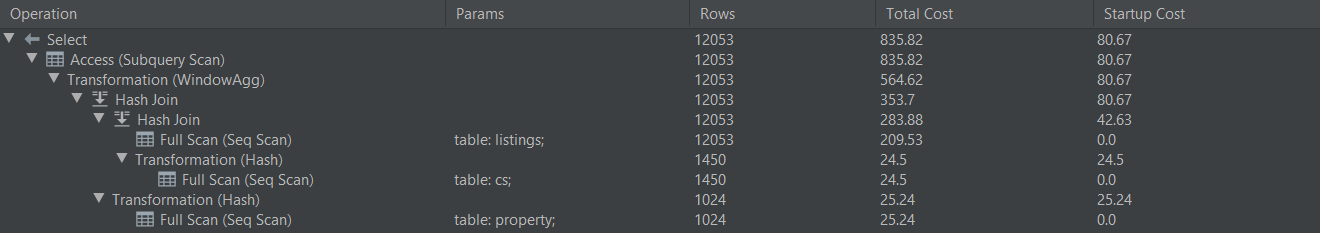

The R system is doing 3 full scans: 

* The first is optional since we are merging tables `listings` and `property` on `property_id`. This column as an automatic hash index, but since these two tables have a one-one relashionship, it's a full scan is more efficient.
* The second full scan is to load the `cs` table, since we want to retrieve all the rows from this table, this is the more efficient approach
* The last full scan is also the must efficient approach since we are merging `listings` to `cs`, where all values of cs are necessary.

All these scans are fully optimized since we need to load completely all these tables. Then R uses hashing to join the tables.

This query is optimized.

#### Normalized Profit

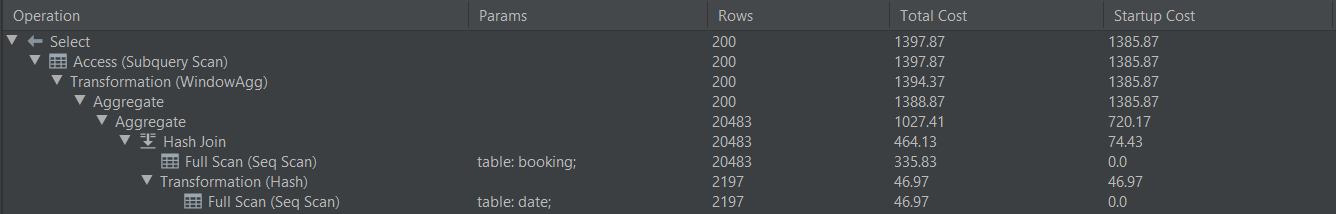

This is also optimized the only full scans that are made, are in tables that need to be completely load to memory. The aggregations are also necessary and cannot be avoided.

#### Metrics View

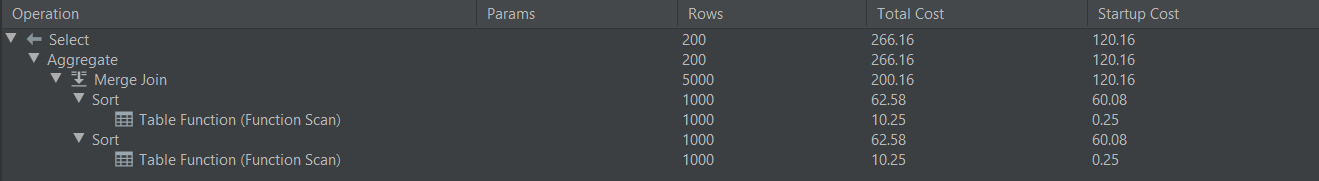

This is a simple query to collect the previous results and build a materialized view. Difficult to optimize since its calling functions, this way is not possible to set an index for the merge, and so two sorts are a merge join are necessary.

#### TOP10 Properties

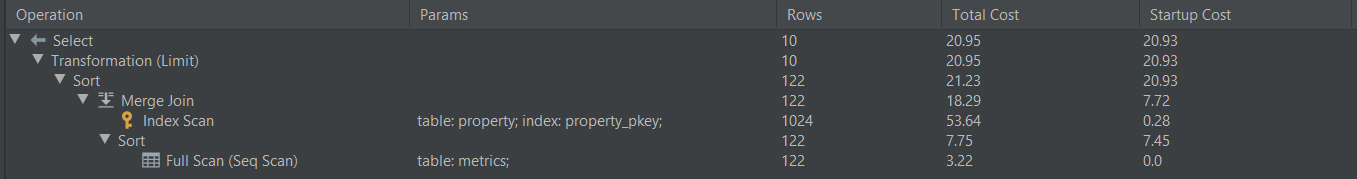

This query is definitely not a bottleneck, but it can be slightly optimized by having an index on the score column, to remove the need for sorting.

In [18]:
index_sql = """
CREATE INDEX score ON metrics(score desc);
"""
conn = psycopg2.connect(host = dbconnection.server_host,database = dbconnection.dbname, user = dbconnection.dbusername,password = dbconnection.dbpassword,sslmode=dbconnection.sslmode)
success = run_sql_command(topn_sql, conn)
if success is True: print('Index Created')

Index Created


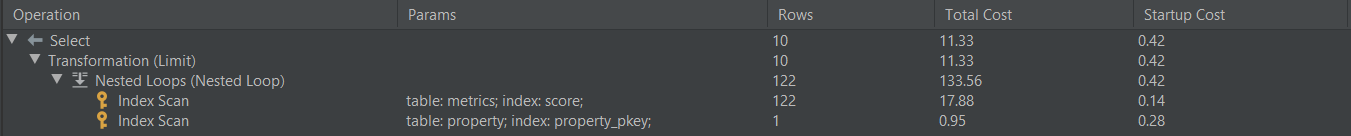

#### Conclusions

There were no bottlenecks, all queries run smoothly, and we can run this notebook almost instantly. The only modification that could improve performance, would be to score review information as numeric variables, but that could prejudice further analyses, like data mining.